In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Mejorando el Aprendizaje

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 16/12/2025

> Asignatura: Programación para la Inteligencia Artificial

Ya hemos visto cómo el algoritmo de ajuste de los pesos durante el entrenamiento puede influir en gran medida en la velocidad de la convergencia del modelo neuronal así como en evitar (o provocar) estancamientos en dicho entrenamiento.

Ahora vamos a centrarnos en cómo otros elementos característicos del Aprendizaje Profundo pueden también contribuir a un mejor aprendizaje. 

## Normalizar el Lote

La normalización del lote (*Batch Normalization*) es una técnica muy habitual destinada, según su diseño original, a compensar el problema de los cambios en las distribuciones de probabilidad que se generan en las capas internas de una red neuronal. Vamos a ver primero el problema que intentan resolver.

imaginemos un MLP con 2 capas líneales. Podemos definir ese MLP como una composición de funciones aprendibles $y=f_{\theta_{2}}(f_{\theta_1}(x))$. Como sabemos, la inicialización de los pesos $\theta_{1}$ y $\theta_{2}$ es aleatoria. La primera capa $f_{\theta_1}$ tiene como entrada directa los valores de entrenamiento $x$ y la segunda capa tiene como valores de entrada la salida de la anterior $f_{\theta_1}(x)$. Esto es obvio, pero vale la pena plantearse una diferencia importante entre cómo se ajusta una capa y otra. La primera capa se tiene que "adaptar" a unas entradas que, aunque cambien según cambian los lotes, representan unas distribuciones de probabilidad implícitas en los datos que no cambian con el tiempo. Sin embargo, la segunda capa se tiene que "adaptar" a las salidas de la anterior. La función $f_{\theta_1}$ transforma las distribuciones de probabilidad presentes en los datos en otras, pero como $f_{\theta_1}$ se está ajustando, esa transformación cambiará según avance el entrenamiento. Por poner un ejemplo extremo: los pesos de $f_{\theta_1}$ podrían hacer que todos los valores $f_{\theta_1}(x)$ sean negativos y, tras algunas épocas, que todos sean positivos. $f_{\theta_{2}}$ inicialmente se estaría ajustando para transformar una distribución que luego cambia, por lo que tiene que ajustarse para transformar debidamente la nueva distribución. Se asume que la distribución de $f_{\theta_1}(x)$ se irá estabilizando y permitirá el debido ajuste a $f_{\theta_{2}}$. Sin embrgo, si pudieramos reducidr esos cambios en la distribución de salida de $f_{\theta_1}(x)$, $f_{\theta_2}$ podría ajustarse con más facilidad.

Esos cambios en las distribuciones de probabilidad en las capas internas se denominan el Desplazamiento Interno de Covariables (*Internal Covariate Shift*) y para compensarlo se propuso en 2015 la normalización por lotes (*Batch Normalization*) como herramienta para normalizar la distribución de salida de las capas y mantener los valores, tengan la distribución que tengan, centrados alrededor del cero y con una varianza más o menos constante (1) utilizando la información del lote. Sea $\mu_{B}$ el vector de medias para el lote de salidas de $z=f_{\theta}(x)$ y $\sigma^2_{B}$ el vector de varianzas, la normalización por lotes se aplica como sigue:

$$\hat{z}=\frac{z-\mu_{B}}{\sqrt{\sigma^{2}_{B}+\epsilon}}$$

$$y = \gamma \hat{z} + \beta$$

Los vectores $\gamma$ y $\beta$ (no confundir con los de los optimizadores) son vectores de pesos aprendibles que se optimizan mediante retropropagación y permiten realizar una transformación lineal sobre los valores normalizados y se inicializan típicamente como un vector de 1s y un vector de 0s respectivamente (de entrada no hacen nada).

El problema de esta aproximación es que requiere un lote lo suficientemente grande para que los valores estadisticos sean significativos. ¿Qué hacemos si queremos aplicar el modelo a un único ejemplo? ¿Obtener la media y desviación típica de sólo un ejemplo para desplazar los valores? No parece prometedor. Por eso durante el entrenamiento se intenta estar una media y una varianza general tal que el vector de medias y varianzas en el paso $t$ se calcula como:

$$\mu_{t} = (1-\alpha) \mu_{t-1} + \alpha \mu_{B,t}$$

$$\sigma^{2}_{t} = (1-\alpha) \sigma^{2}_{t-1} + \alpha \sigma^{2}_{B,t}$$

El parámetro $\alpha$ permite gestionar cuánto influye cada nuevo vector estadistico respecto a los almacenados anteriormente. Un funcionamiento similar al observado en el RMSProp.

Cuando no se está entrenando, en vez de usar $\mu_{B}$ o $\sigma^2_{B}$. Esto implica que este elemento no funciona exactamente igual al hacer un paso hacia delante dentro y fuera del entrenamiento. Durante el entrenamiento usará los valores del lote para la normalización y actualizará la estimación de las medias y varianzas generales y fuera del entrenamiento usa estas medias y varianzas generales sin actualizarlas.

Es el momento de introducir una funcionalidad de PyTorch: los métodos **.eval()** y **.train()** de cualquier **nn.Module**. Al usar el método **.train()**, el módulo (y sus componentes que a su vez lo son) activará su comportamiento esperable durante el entrenamiento, mientras que **.eval()** activa el comportamiento esperable fuera del entrenamiento.

Vamos a ver cómo se integra esto en un bucle de entrenamiento:

In [2]:
def learning_loop_for_classification(train_dataloader, val_dataloader, model, epochs, loss_fn, optimizer, validation_freq):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  with tqdm(range(epochs), desc="epoch") as pbar:
    for epoch in pbar:
      model.train()
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        optimizer.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        model.eval()
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

  return model, epoch_loss_list, val_loss_list, val_acc_list

Como se puede observar, la lógica es sencilla. Al iniciar una época de entrenamiento llamamos a **.train()** para indicar que deseamos el comportamiento de sus componentes acorde a un proceso de entrenamiento. Cuando iniciamos un paso de evaluación usamos **.eval()** para indicar que deseamos el comportamiento fuera del entrenamiento.

En PyTorch, la normalización por lotes para una dimensión la implementa la clase **torch.nn.BatchNorm1d**. Vamos a hacer un experimento de ejemplo para el que vamos a rescatar elementos de otros cuadernos.

In [3]:
DRIVE=False
if DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'
else:
  workpath = '/workspace/data'

In [4]:
train_dataset = datasets.CIFAR10(root=workpath, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root=workpath, train=False, download=True, transform=transforms.ToTensor())

In [5]:
device = 'cuda'
device = torch.device("cuda:0" if (device == 'cuda') and torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class CudaDataset(Dataset):
  def __init__(self, dataset, device, transform = None):
    self.dataset = dataset
    self.cuda_y = []
    self.cuda_x = []
    self.device = device
    self.transform = transform

    for x, y in tqdm(self.dataset, desc="Moving to GPU"):
      self.cuda_x.append(x.to(self.device))
      self.cuda_y.append(torch.tensor(y, device=self.device))

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if self.transform is None:
      x = self.cuda_x[idx]
    else:
      x = self.transform(self.cuda_x[idx])
    return x, self.cuda_y[idx]

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

In [7]:
transforms_policy = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root=workpath, train=True, download=True, transform=transforms_policy)
val_dataset = datasets.CIFAR10(root=workpath, train=False, download=True, transform=transforms_policy)

In [8]:
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")

Número de ejemplos en entrenamiento: 50000
Número de ejemplos en validación: 10000


In [9]:
learning_rate = 1e-3
epochs = 200
batch_size = 1024
loss_fn = torch.nn.CrossEntropyLoss()
validation_freq = 1

if not str(device)=="cpu":
  val_dataset = CudaDataset(val_dataset, device)
  train_dataset = CudaDataset(train_dataset, device)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

Moving to GPU: 100%|██████████| 50000/50000 [00:07<00:00, 6750.55it/s]


Para empezar vamos a entrenar un MLP sencillo.

In [10]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:47<00:00,  4.18it/s, loss=0.5220980644226074]


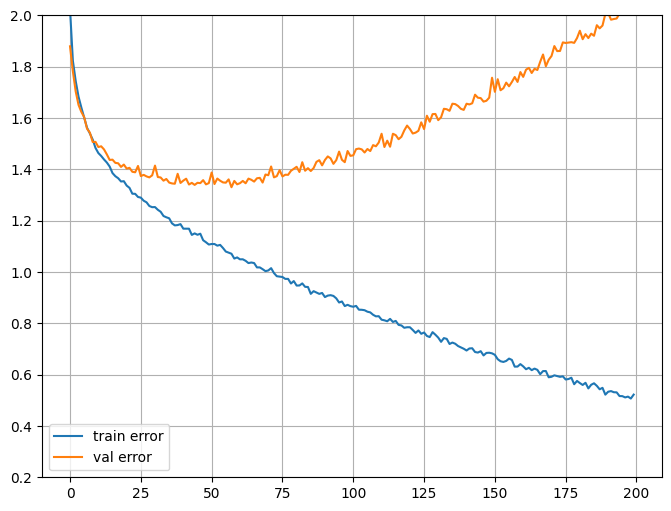

In [11]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0.2, top=2)
plt.show()

A continuación vamos a introducir una "capa" de normalización de lote tras la primera capa.

In [12]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm1d(128),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

#print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:50<00:00,  3.94it/s, loss=0.04321255162358284] 


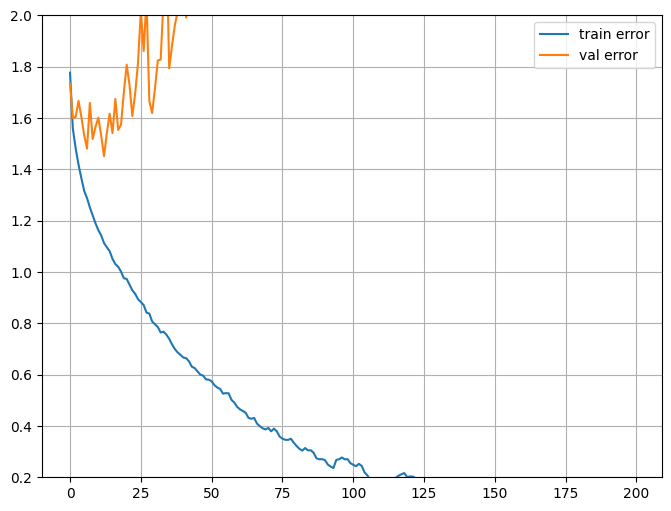

In [13]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0.2, top=2)
plt.show()

¡Parece que la presencia de la normalización por lote efectivamente facilita el aprendizaje, tanto que aumenta el sobreajuste! ^^U

Como última nota tenemos que señalar que aún existe discusión sobre por qué está técnica funciona. Aunque la intención original de sus autores sobre corregir los cambios en las distribuciones, existen investigaciones que sugieren que la ventaja de está técnica radica en que hace que suaviza el espacio de gradientes, disminuyendo la "brusquedad" de las actualizaciones.

## Dropout

El *dropout* (que podríamos traducir como Descarte Aleatorio de Neuronas) es una técnica para reducir el sobreajuste de las redes basada en descartar aleatoriamente neuronas (lo sé, lo sé). La técnica se basa en la idea de que el sobreajuste lo provoca la co-adaptación. Las neuronas se adaptan demasiado bien a combinar sus salidas de manera concreta para obtener los resultados del conjunto de entrenamiento. La idea del *dropout* es que si desactivamos aleatoriamente algunas neuronas en cada paso hacia adelante durante el entrenamiento será más dificil que aparezcan estas combinaciones específicas. Fuera del entrenamiento se mantienen todas las neuronas activas.

Dada una probabilidad $p$ de apagar una neurona, obtenemos:

$$r_{i} \sim Bernoulli(1-p)$$

Recordatorio: la distribución de Bernoulli es 1 con probabilidad $1-p$ y 0 en otro caso.

Si $y_{i}$ es la salida de una neurona concreta, su salida tras aplicar *dropout* es:

$$\hat{y_{i}} = \frac{r_{i}}{1-p} y_{i}$$

$r_{i}$ es 1 o 0 y determina si la neurona está "activa". Ahí no hay mucha dificultad. ¿Qué es el $\frac{1}{1-p}$ entonces? Un factor de escalado necesario para mantener la media. Vamos a ver un ejemplo sencillo. Supongamos que tenemos una capa con cien neuronas que para un ejemplo concreto tienen una salida $y_{i}=10$ (sí, todas las neuronas en la capa tienen la misma salida). Si esas neuronas tienen una probabilidad de desactivarse $p=0.5$, durante el entrenamiento a veces tendrán un resultado de 0 y a veces un resultado de 10. Una hipotética neurona lineal en la siguiente capa que esté conectada a las cien anteriores recibirá un vector que sume de media $\mathbb{E}[\sum_{i} \hat{y_{i}}] = \sum_{i} 0p+(1-p)10 = 500$. Sin embargo, fuera del entrenamiento (que no desactivamos ninguna neurona), la suma de ese vector de activaciones será $\sum_{i} 10 = 1000$. Para que se mantenga la media de las activaciones durante el entrenamiento se escalan proporcionalmente los resultados de las neuronas activas. Cuando una neurona está activa, se le da más importancia en proporción a la probabilidad de que estuviera desactivada.

La idea intuitiva es que el *dropout* fuerza a la red a crear redundancias, que distintas neuronas cumplan la misma función dentro del sistema (por si alguna cae), y dificulta que los resultados dependan de combinaciones muy específicas de neuronas. El precio a pagar es que dificultamos a la red aprender en general y pierde capacidad.

En Pytorch, el dropout se añade como si fuera una capa con la clase **torch.nn.Dropout**. Por defecto la probabilidad de desactivar las neuronas es 0.5.

Igual que con la normalización del lote que hemos comentado antes, el comportamiento del *dropout* es distinto dentro del entrenamiento y fuera de él. Por tanto, también requiere que usemos **.eval()** y **.train()** debidamente.





In [14]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )


model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:48<00:00,  4.14it/s, loss=0.5220980644226074]


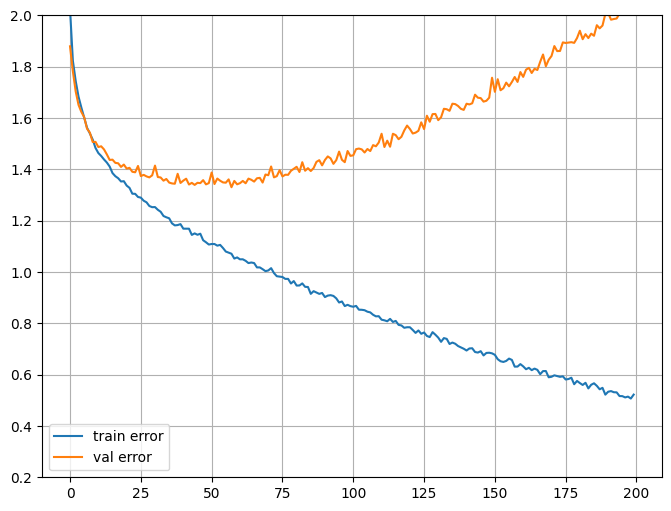

In [15]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0.2, top=2)
plt.show()

In [16]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.LazyLinear(128),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(128,10)
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
  )

model, train_loss_list, val_loss_list, val_acc_list = learning_loop_for_classification(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    optimizer,
    validation_freq = validation_freq)

epoch: 100%|██████████| 200/200 [00:49<00:00,  4.03it/s, loss=1.4062925577163696]


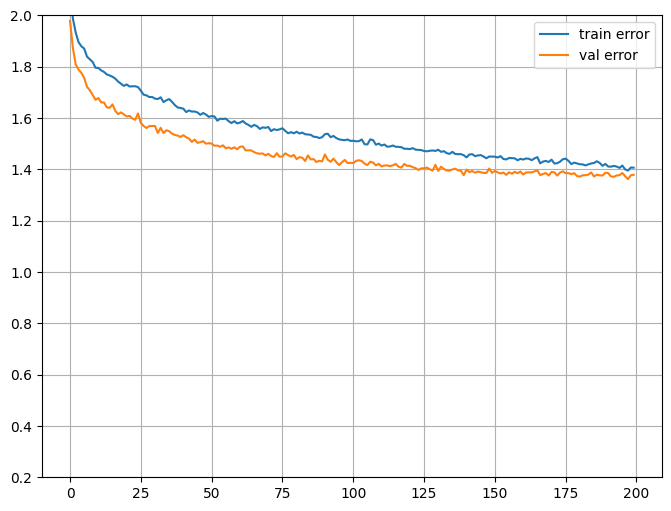

In [17]:
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [l.cpu() for l in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [l.cpu() for l in val_loss_list], label="val error")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0.2, top=2)
plt.show()

En esencia esta técnica obliga a la red a que sea más versatil y dedique "recursos" a la robustez en lugar de a ajustarse demasiado bien a los datos. Por supuesto, una red lo suficientemente grande para el problema con el suficiente tiempo también puede caer en el sobreentrenamiento (como le ocurre a la que hemos entrenado).

El *dropout* es una técnica controvertida. Aunque se ha utilizado ampliamente, hay autores que cuestionan si es contraproducente la dificultad añadida al aprendizaje comparado con las ventajas que demuestra. De hecho en nuestro ejemplo vemos que la versión sin *dropout* tiene el mínimo de validación más bajo que la versión con *dropout*. Como otras técnicas de Aprendizaje Profundo, hay que aplicarla y observar el efecto que tiene para decidir si conviene a nuestro problema.